In [1]:
import joblib

# Add project root to the Python path
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.base import clone

import scipy.sparse

# access utilities

import sys
from pathlib import Path

# Adjust the system path to include the project root directory. 
# It assumes the notebook is inside 'scripts/model_training'.
project_root = Path.cwd().parents[1]
sys.path.insert(0, str(project_root))

# Import the project configuration settings.
import config
from config import RANDOM_SEED
config.set_seed()

# Import the DataPreprocessingPipeline class from 'utils' in 'scripts/preprocessing'.
from utils import DataPreprocessingPipeline

In [2]:

# Use the load_data function from config to load .sas7bdat file
emergency_df = config.load_data('nhamcs14.sas7bdat', 'raw')

In [3]:
# Please update the below based on your specific need

target = 'LOV'
target_to_drop = ['WAITTIME_BINARY','LOV_BINARY']
        
# Instantiate the data preprocessing pipeline
pipeline = DataPreprocessingPipeline(emergency_df=emergency_df,target=target,target_to_drop=target_to_drop,percent_train=0.70,percent_val=0.15,percent_test=0.15,stratify=False)

# Run the pipeline
pipeline.run()

X_train = pipeline.X_train
X_validation = pipeline.X_validation
X_test = pipeline.X_test

train_df = pipeline.train_df
validation_df = pipeline.validation_df
test_df = pipeline.test_df

y_train = pipeline.y_train
y_validation = pipeline.y_validation
y_test = pipeline.y_test
print("Length y_test",len(y_test))

X_train_preprocessed = pipeline.X_train_preprocessed
X_validation_preprocessed = pipeline.X_validation_preprocessed
X_test_preprocessed = pipeline.X_test_preprocessed

feature_names = pipeline.feature_names

cleaned_emergency_df = pipeline.cleaned_emergency_df 
transformed_emergency_df = pipeline.transformed_emergency_df

# Ensure feature_names is treated as a list
feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]
feature_names_list = list(feature_names)
config.save_data(feature_names, f"features_{target}.csv", 'features')

1-Cleaning data...
Data cleaning completed
Size of Initial dataset:(23844, 1012)
Size of cleaned dataset:(17959, 370)

2-Applying feature engineering...
Feature engineering completed
Size of the dataset after feature engineering:(17959, 387)

3-Splitting data...
self.stratify: False
Splitting data completed

4-Loading data...
train_df size: (12571, 387)
X_train size: (12571, 386)
y_train size: (12571,)

validation_df size: (2693, 387)
X_validation size: (2693, 386)
y_validation size: (2693,)

test_df size: (2695, 387)
X_test size: (2695, 386)
y_test size: (2695,)
Loading data completed

5-Preprocessing data...
Preprocessing data completed.
Processor saved successfully
Length y_test 2695


In [4]:
# Define dictionary of models with their default parameters
models_with_defaults = {
    "CatBoostRegressor": {
        "model": CatBoostRegressor(random_state=RANDOM_SEED, verbose=0)
    },
    "LGBMRegressor": {
        "model": LGBMRegressor(
            random_state=RANDOM_SEED, force_col_wise=True, verbosity=-1
        )
    },
    "Ridge": {"model": Ridge()},
    "Lasso": {"model": Lasso()},
    "GradientBoostingRegressor": {
        "model": GradientBoostingRegressor(random_state=RANDOM_SEED)
    },
    "XGBRegressor": {"model": XGBRegressor(random_state=RANDOM_SEED)},
}

best_model = None
best_mae = float("inf")  # Initialize with infinity
best_r2 = -float("inf")  # Initialize with negative infinity
scoring = ["neg_mean_absolute_error", "r2"]
R2_TOLERANCE = 0.05
MAE_TOLERANCE = 0.01

# Prepare X_train_selected_features based on the format of X_train_preprocessed
if scipy.sparse.issparse(X_train_preprocessed):
    X_train_selected_features = X_train_preprocessed.toarray()
else:
    X_train_selected_features = X_train_preprocessed

# Loop over each model and evaluate their performance using cross-validation
for model_name, model_info in models_with_defaults.items():
    model = model_info["model"]
    print(f"Cross-validating model: {model_name}...")

    # Perform cross-validation
    cv_results = cross_validate(
        model, X_train_selected_features, y_train, cv=5, scoring=scoring
    )

    # Calculate the average of the cross-validation scores
    mean_mae_validation = -1 * cv_results["test_neg_mean_absolute_error"].mean()
    mean_r2_validation = cv_results["test_r2"].mean()

    print(f"Model: {model_name}")
    print(f"Cross-Validation MAE: {mean_mae_validation:.2f}")
    print(f"Cross-Validation R-squared: {mean_r2_validation:.2f}")
    print()

    # Update best model if current model performs better based on MAE and R2
    if (
        (mean_mae_validation < best_mae and mean_r2_validation > best_r2)
        or (
            mean_mae_validation < best_mae
            and mean_r2_validation >= best_r2 * (1 - R2_TOLERANCE)
        )
        or (
            mean_mae_validation <= best_mae * (1 + MAE_TOLERANCE)
            and mean_r2_validation > best_r2
        )
        or (mean_r2_validation == best_r2 and mean_mae_validation < best_mae)
    ):
        best_model = model
        best_mae = mean_mae_validation
        best_r2 = mean_r2_validation

# Display the best model based on cross-validation
print("Best Model Based on Cross-Validation:")
print(f"Model Name: {best_model.__class__.__name__}")  # Adjusted to show class name
print(f"Best Cross-Validation MAE: {best_mae:.2f}")
print(f"Best Cross-Validation R-squared: {best_r2:.2f}")

# Save the best model instance, not its name
model_filename = "best_waittime_regression_model.joblib"
# Adjusted to directly save the model instance
config.save_model(best_model, model_filename)
print(f"{model_filename} saved")

Cross-validating model: CatBoostRegressor...
Model: CatBoostRegressor
Cross-Validation MAE: 51.04
Cross-Validation R-squared: 0.56

Cross-validating model: LGBMRegressor...
Model: LGBMRegressor
Cross-Validation MAE: 52.12
Cross-Validation R-squared: 0.54

Cross-validating model: Ridge...
Model: Ridge
Cross-Validation MAE: 54.71
Cross-Validation R-squared: 0.50

Cross-validating model: Lasso...
Model: Lasso
Cross-Validation MAE: 55.54
Cross-Validation R-squared: 0.49

Cross-validating model: GradientBoostingRegressor...
Model: GradientBoostingRegressor
Cross-Validation MAE: 53.69
Cross-Validation R-squared: 0.52

Cross-validating model: XGBRegressor...
Model: XGBRegressor
Cross-Validation MAE: 54.15
Cross-Validation R-squared: 0.51

Best Model Based on Cross-Validation:
Model Name: CatBoostRegressor
Best Cross-Validation MAE: 51.04
Best Cross-Validation R-squared: 0.56
best_waittime_regression_model.joblib saved


In [5]:
# import pandas as pd
# from sklearn.model_selection import cross_validate
# from sklearn.linear_model import Ridge, Lasso
# from sklearn.ensemble import GradientBoostingRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
# import scipy

# # Define random seed for reproducibility
# RANDOM_SEED = 42

# # Define dictionary of models with their default parameters
# models_with_defaults = {
#     "CatBoostRegressor": {
#         "model": CatBoostRegressor(random_state=RANDOM_SEED, verbose=0)
#     },
#     "LGBMRegressor": {
#         "model": LGBMRegressor(
#             random_state=RANDOM_SEED, force_col_wise=True, verbosity=-1
#         )
#     },
#     "Ridge": {"model": Ridge()},
#     "Lasso": {"model": Lasso()},
#     "GradientBoostingRegressor": {
#         "model": GradientBoostingRegressor(random_state=RANDOM_SEED)
#     },
#     "XGBRegressor": {"model": XGBRegressor(random_state=RANDOM_SEED)},
# }

# best_model = None
# best_mae = float("inf")  # Initialize with infinity
# best_r2 = -float("inf")  # Initialize with negative infinity
# scoring = ["neg_mean_absolute_error", "r2"]
# R2_TOLERANCE = 0.05
# MAE_TOLERANCE = 0.01

# # Example placeholder for X_train_preprocessed and y_train
# # X_train_preprocessed = np.array([...])
# # y_train = np.array([...])

# # Prepare X_train_selected_features based on the format of X_train_preprocessed
# if scipy.sparse.issparse(X_train_preprocessed):
#     X_train_selected_features = X_train_preprocessed.toarray()
# else:
#     X_train_selected_features = X_train_preprocessed

# results = []

# # Loop over each model and evaluate their performance using cross-validation
# for model_name, model_info in models_with_defaults.items():
#     model = model_info["model"]
#     print(f"Cross-validating model: {model_name}...")

#     # Perform cross-validation
#     cv_results = cross_validate(
#         model, X_train_selected_features, y_train, cv=5, scoring=scoring
#     )

#     # Calculate the average of the cross-validation scores
#     mean_mae_validation = (-1 * cv_results["test_neg_mean_absolute_error"].mean()).round(2)
#     mean_r2_validation = (cv_results["test_r2"].mean()).round(2)

#     results.append({
#         "Model Name": model_name,
#         "MAE": mean_mae_validation,
#         "R2": mean_r2_validation
#     })

#     # Update best model if current model performs better based on MAE and R2
#     if (
#         (mean_mae_validation < best_mae and mean_r2_validation > best_r2)
#         or (
#             mean_mae_validation < best_mae
#             and mean_r2_validation >= best_r2 * (1 - R2_TOLERANCE)
#         )
#         or (
#             mean_mae_validation <= best_mae * (1 + MAE_TOLERANCE)
#             and mean_r2_validation > best_r2
#         )
#         or (mean_r2_validation == best_r2 and mean_mae_validation < best_mae)
#     ):
#         best_model = model
#         best_mae = mean_mae_validation
#         best_r2 = mean_r2_validation

# # Create a DataFrame from the results
# results_df = pd.DataFrame(results)
# results_df['Is Best Model'] = (results_df['Model Name'] == best_model.__class__.__name__).map({True: 'Yes', False: 'No'})

# # Display the best model based on cross-validation
# print("Best Model Based on Cross-Validation:")
# print(f"Model Name: {best_model.__class__.__name__}")
# print(f"Best Cross-Validation MAE: {best_mae:.2f}")
# print(f"Best Cross-Validation R-squared: {best_r2:.2f}")

# # Display the summary table
# print("Summary of Model Performance:")
# print(results_df.to_string(index=False))

# # Save the best model instance, not its name
# model_filename = "best_waittime_regression_model.joblib"
# # Adjusted to directly save the model instance
# # config.save_model(best_model, model_filename)  # Uncomment this line after defining config.save_model
# print(f"{model_filename} saved")


In [8]:

# Define dictionary of models with their default parameters
models_with_defaults = {
    "CatBoostRegressor": {
        "model": CatBoostRegressor(random_state=RANDOM_SEED, verbose=0)
    },
    "LGBMRegressor": {
        "model": LGBMRegressor(
            random_state=RANDOM_SEED, force_col_wise=True, verbosity=-1
        )
    },
    "Ridge": {"model": Ridge()},
    "Lasso": {"model": Lasso()},
    "GradientBoostingRegressor": {
        "model": GradientBoostingRegressor(random_state=RANDOM_SEED)
    },
    "XGBRegressor": {"model": XGBRegressor(random_state=RANDOM_SEED)},
}

best_model = None
best_mae = float("inf")  # Initialize with infinity
best_r2 = -float("inf")  # Initialize with negative infinity
scoring = ["neg_mean_absolute_error", "r2"]
R2_TOLERANCE = 0.05
MAE_TOLERANCE = 0.01


# Prepare X_train_selected_features based on the format of X_train_preprocessed
if scipy.sparse.issparse(X_train_preprocessed):
    X_train_selected_features = X_train_preprocessed.toarray()
else:
    X_train_selected_features = X_train_preprocessed

results = []

# Loop over each model and evaluate their performance using cross-validation
for model_name, model_info in models_with_defaults.items():
    model = model_info["model"]
    print(f"Cross-validating model: {model_name}...")

    # Perform cross-validation
    cv_results = cross_validate(
        model, X_train_selected_features, y_train, cv=5, scoring=scoring
    )

    # Calculate the average of the cross-validation scores
    mean_mae_validation = -1 * cv_results["test_neg_mean_absolute_error"].mean()
    mean_r2_validation = cv_results["test_r2"].mean()


    mean_full = cleaned_emergency_df[target].mean()

    # Add the means as new columns
    # results[f"Mean {target}"] = round(mean_full, 2)

    results.append({
        "Model Name": model_name,
        f"Mean {target}":  mean_full, 
        "MAE": mean_mae_validation,
        "R2": mean_r2_validation
    })

    # Update best model if current model performs better based on MAE and R2
    if (
        (mean_mae_validation < best_mae and mean_r2_validation > best_r2)
        or (
            mean_mae_validation < best_mae
            and mean_r2_validation >= best_r2 * (1 - R2_TOLERANCE)
        )
        or (
            mean_mae_validation <= best_mae * (1 + MAE_TOLERANCE)
            and mean_r2_validation > best_r2
        )
        or (mean_r2_validation == best_r2 and mean_mae_validation < best_mae)
    ):
        best_model = model
        best_mae = mean_mae_validation
        best_r2 = mean_r2_validation

# Create a DataFrame from the results
results_df = pd.DataFrame(results)
results_df['Is Best Model'] = (results_df['Model Name'] == best_model.__class__.__name__).map({True: 'Yes', False: 'No'})


# Round the numerical columns to two decimal places
results_df[[f"Mean {target}",'MAE', 'R2']] = results_df[[f"Mean {target}",'MAE', 'R2']].round(2)

# Display the best model based on cross-validation
print("Best Model Based on Cross-Validation:")
print(f"Model Name: {best_model.__class__.__name__}")
print(f"Best Cross-Validation MAE: {best_mae:.2f}")
print(f"Best Cross-Validation R-squared: {best_r2:.2f}")


# Save the best model instance, not its name
model_filename = "best_waittime_regression_model.joblib"
# Adjusted to directly save the model instance
config.save_model(best_model, model_filename) 
print(f"{model_filename} saved")



Cross-validating model: CatBoostRegressor...
Cross-validating model: LGBMRegressor...
Cross-validating model: Ridge...
Cross-validating model: Lasso...
Cross-validating model: GradientBoostingRegressor...
Cross-validating model: XGBRegressor...
Best Model Based on Cross-Validation:
Model Name: CatBoostRegressor
Best Cross-Validation MAE: 51.04
Best Cross-Validation R-squared: 0.56
best_waittime_regression_model.joblib saved


In [9]:
results_df


,Model Name,Mean LOV,MAE,R2,Is Best Model
0,CatBoostRegressor,170.45,51.04,0.56,Yes
1,LGBMRegressor,170.45,52.12,0.54,No
2,Ridge,170.45,54.71,0.50,No
3,Lasso,170.45,55.54,0.49,No
4,GradientBoostingRegressor,170.45,53.69,0.52,No
5,XGBRegressor,170.45,54.15,0.51,No


100%|===================| 12566/12571 [03:06<00:00]        

n: 10, MAE: 54.98, R²: 0.48


100%|===================| 12567/12571 [03:05<00:00]        

n: 15, MAE: 54.30, R²: 0.49


100%|===================| 12523/12571 [03:12<00:00]        

n: 20, MAE: 53.31, R²: 0.51


100%|===================| 12570/12571 [03:07<00:00]        

n: 25, MAE: 52.41, R²: 0.52


100%|===================| 12567/12571 [03:09<00:00]        

n: 30, MAE: 51.99, R²: 0.52


100%|===================| 12566/12571 [03:05<00:00]        

n: 40, MAE: 51.40, R²: 0.53


100%|===================| 12548/12571 [03:05<00:00]        

n: 50, MAE: 51.48, R²: 0.53


100%|===================| 12528/12571 [03:04<00:00]        

n: 60, MAE: 51.47, R²: 0.53


100%|===================| 12512/12571 [03:16<00:00]        

n: 70, MAE: 51.55, R²: 0.53


100%|===================| 12526/12571 [03:10<00:00]        

n: 80, MAE: 51.27, R²: 0.54


100%|===================| 12512/12571 [03:10<00:00]        

n: 90, MAE: 50.95, R²: 0.54


100%|===================| 12526/12571 [03:03<00:00]        

n: 100, MAE: 51.01, R²: 0.54


100%|===================| 12554/12571 [03:03<00:00]        

n: 150, MAE: 50.66, R²: 0.54


100%|===================| 12564/12571 [03:04<00:00]        

n: 200, MAE: 50.72, R²: 0.54


100%|===================| 12565/12571 [03:04<00:00]        

n: 300, MAE: 50.67, R²: 0.54

Best Model Configuration to Avoid Overfitting:
Best n: 150, Best MAE: 50.66, Best R²: 0.54


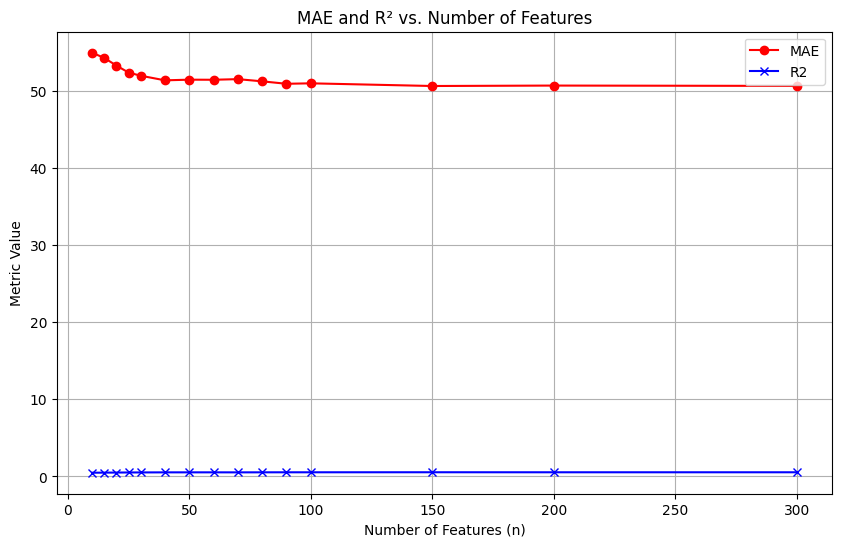

In [10]:
# Define a function to calculate SHAP values and return feature importances
def get_shap_importance(model, X_train):
    """Calculate SHAP values and return sorted feature importances."""
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer.shap_values(X_train)
    shap_importances = np.abs(shap_values).mean(axis=0)
    return shap_importances


# Define a function to fit a model using selected features and evaluate it
def evaluate_model_with_shap(
    model, X_train, y_train, X_validation, y_validation, feature_names, n
):
    """Fit model, evaluate it, and return MAE, R2, and sorted features by importance."""
    model.fit(X_train, y_train)
    shap_importances = get_shap_importance(model, X_train)
    indices = np.argsort(shap_importances)[::-1][
        :n
    ]  # Get indices of the top n important features
    selected_feature_names = np.array(feature_names)[
        indices
    ]  # Sort feature names by importance

    X_train_n = X_train[:, indices]
    X_validation_n = X_validation[:, indices]

    model.fit(X_train_n, y_train)  # Refit model on selected features
    y_pred = model.predict(X_validation_n)
    mae = mean_absolute_error(y_validation, y_pred)
    r2 = r2_score(y_validation, y_pred)

    return mae, r2, selected_feature_names, shap_importances[indices]


# Assuming `X_train_preprocessed`, `X_validation_preprocessed` are numpy arrays directly
X_train_np = X_train_preprocessed
X_validation_np = X_validation_preprocessed

best_n = None
best_mae = float("inf")
best_r2 = -float("inf")
best_features = []
MAE_TOLERANCE = 0.01
R2_TOLERANCE = 0.01
n_list = [10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300]
feature_names = [
    name.replace("num__", "").replace("cat__", "") for name in feature_names_list
]

mae_list = []
r2_list = []

# Evaluate model for different values of n
for n in n_list:
    model = clone(best_model)  # Reset the model
    mae, r2, selected_features, feature_importances = evaluate_model_with_shap(
        model, X_train_np, y_train, X_validation_np, y_validation, feature_names, n
    )
    print(f"n: {n}, MAE: {mae:.2f}, R²: {r2:.2f}")
    # print(f"Features (ordered by importance): {selected_features}")
    # print(f"Importances: {feature_importances}")
    mae_list.append(mae)
    r2_list.append(r2)

    if (
        (mae < best_mae and r2 > best_r2)
        or (mae < best_mae and r2 >= best_r2 * (1 - R2_TOLERANCE))
        or (mae <= best_mae * (1 + MAE_TOLERANCE) and r2 > best_r2)
        or (r2 == best_r2 and mae < best_mae)
    ):
        best_n = n
        best_mae = mae
        best_r2 = r2
        best_features = selected_features

# Output the best model configuration
print("\nBest Model Configuration to Avoid Overfitting:")
print(f"Best n: {best_n}, Best MAE: {best_mae:.2f}, Best R²: {best_r2:.2f}")
# print("Best Features (ordered by importance):", best_features)

# Plotting MAE and R2 vs n
plt.figure(figsize=(10, 6))
plt.plot(n_list, mae_list, label="MAE", color="red", marker="o")
plt.plot(n_list, r2_list, label="R2", color="blue", marker="x")
plt.title("MAE and R² vs. Number of Features")
plt.xlabel("Number of Features (n)")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.show()

100%|===================| 12556/12571 [03:04<00:00]        

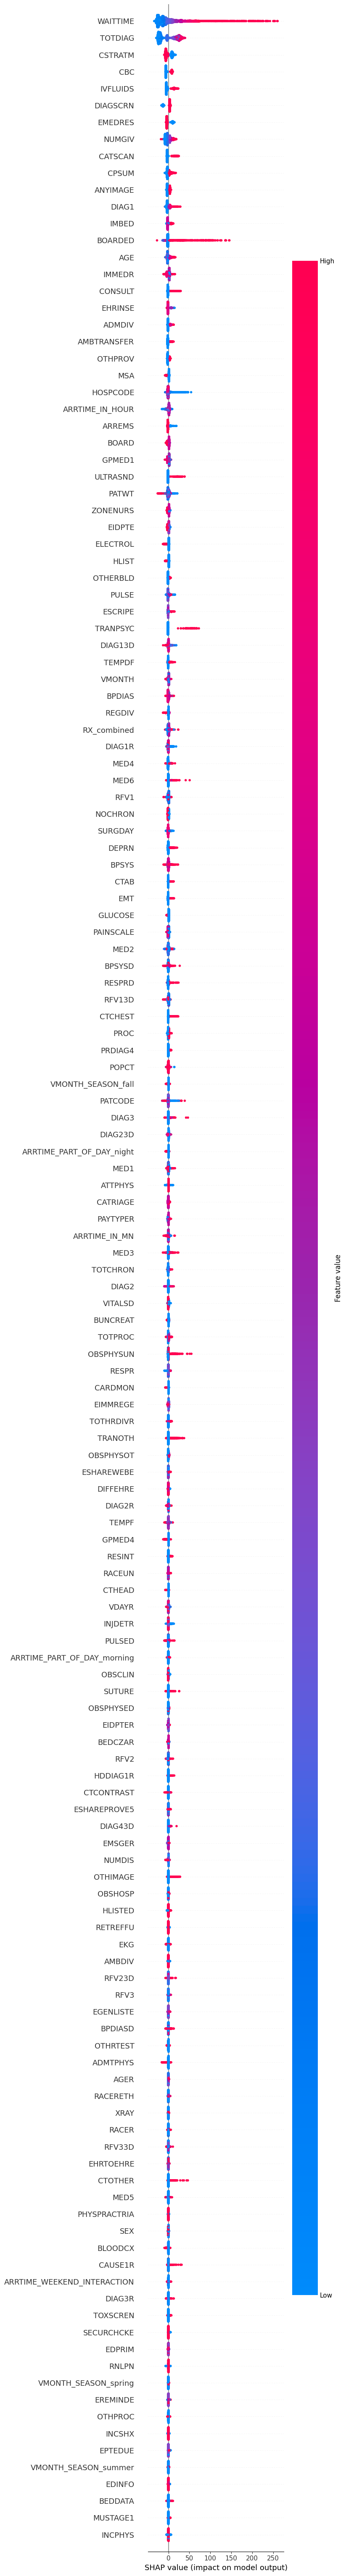

Top N Features (Cleaned Names): ['WAITTIME' 'TOTDIAG' 'CSTRATM' 'CBC' 'IVFLUIDS' 'DIAGSCRN' 'EMEDRES'
 'NUMGIV' 'CATSCAN' 'CPSUM' 'ANYIMAGE' 'DIAG1' 'IMBED' 'BOARDED' 'AGE'
 'IMMEDR' 'CONSULT' 'EHRINSE' 'ADMDIV' 'AMBTRANSFER' 'OTHPROV' 'MSA'
 'HOSPCODE' 'ARRTIME_IN_HOUR' 'ARREMS' 'BOARD' 'GPMED1' 'ULTRASND' 'PATWT'
 'ZONENURS' 'EIDPTE' 'ELECTROL' 'HLIST' 'OTHERBLD' 'PULSE' 'ESCRIPE'
 'TRANPSYC' 'DIAG13D' 'TEMPDF' 'VMONTH' 'BPDIAS' 'REGDIV' 'RX_combined'
 'DIAG1R' 'MED4' 'MED6' 'RFV1' 'NOCHRON' 'SURGDAY' 'DEPRN' 'BPSYS' 'CTAB'
 'EMT' 'GLUCOSE' 'PAINSCALE' 'MED2' 'BPSYSD' 'RESPRD' 'RFV13D' 'CTCHEST'
 'PROC' 'PRDIAG4' 'POPCT' 'VMONTH_SEASON_fall' 'PATCODE' 'DIAG3' 'DIAG23D'
 'ARRTIME_PART_OF_DAY_night' 'MED1' 'ATTPHYS' 'CATRIAGE' 'PAYTYPER'
 'ARRTIME_IN_MN' 'MED3' 'TOTCHRON' 'DIAG2' 'VITALSD' 'BUNCREAT' 'TOTPROC'
 'OBSPHYSUN' 'RESPR' 'CARDMON' 'EIMMREGE' 'TOTHRDIVR' 'TRANOTH'
 'OBSPHYSOT' 'ESHAREWEBE' 'DIFFEHRE' 'DIAG2R' 'TEMPF' 'GPMED4' 'RESINT'
 'RACEUN' 'CTHEAD' 'VDAYR' 'INJDETR' 'PULS

In [11]:
# Assuming `best_model` is already defined and properly trained
model = clone(best_model)
model.fit(X_train_preprocessed, y_train)  # Ensure model is fitted


def plot_shap_summary(model, X_train_preprocessed, feature_names, n):
    """
    Plots SHAP summary plot of the top N features.

    Parameters:
    - model: The trained model.
    - X_train_preprocessed: The preprocessed training data.
    - feature_names: Names of the features after preprocessing.
    - n: Number of top features to consider.
    """
    # Initialize the SHAP Tree explainer and compute SHAP values
    explainer = shap.Explainer(model, X_train_preprocessed)
    shap_values = explainer.shap_values(X_train_preprocessed)

    # Plot the SHAP summary plot for the top N features
    shap.summary_plot(
        shap_values,
        X_train_preprocessed,
        feature_names=feature_names,
        max_display=n,
        show=True,
    )


# Extract top N features based on the earlier best_features selection
n = best_n  # This should be set from the previous analysis
feature_names_list = [
    name.replace("num__", "").replace("cat__", "") for name in feature_names_list
]  # Assuming this preprocessing is needed

# Call the function to plot SHAP values for the top N feature names
plot_shap_summary(
    model=model,
    X_train_preprocessed=X_train_preprocessed,
    feature_names=feature_names_list,
    n=n,
)

# After plotting, continue with any additional processing or saving
top_features = best_features
print("Top N Features (Cleaned Names):", top_features)

# Extracting indices of top features directly since prefixes have been removed
top_feature_indices = [feature_names_list.index(feature) for feature in top_features]

X_train_selected_features = X_train_preprocessed[:, top_feature_indices]
X_validation_selected_features = (
    X_validation_preprocessed[:, top_feature_indices]
    if X_validation_preprocessed.size > 0
    else X_validation_preprocessed
)
X_test_selected_features = X_test_preprocessed[:, top_feature_indices]

# Save top n features
config.save_data(top_features, f"top_features_{target}.csv", "features")
config.save_data(top_feature_indices, f"feature_indices_{target}.csv", "features")

config.save_data(
    X_train_selected_features,
    f"X_train_selected_features_{target}.csv",
    subdir="train",
    column_names=top_features,
)
config.save_data(
    X_validation_selected_features,
    f"X_validation_selected_features_{target}.csv",
    subdir="validation",
    column_names=top_features,
)
config.save_data(
    X_test_selected_features,
    f"X_test_selected_features_{target}.csv",
    subdir="test",
    column_names=top_features,
)